In [1]:
!pip3 install ipywidgets

In [29]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive

from sklearn.model_selection import train_test_split
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('zmienne/usdpln_d.csv')

In [4]:
#podzial na zbior treningow, testowy, walidacyjny

In [5]:
ratio = 0.6
N = int(len(data)*ratio)

In [6]:
train_df, test_df = data[:N], data[N:]

In [7]:
ratio = 0.5
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]

In [8]:
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
count,1709.000000,1709.000000,1709.000000,1709.000000
mean,3.283205,3.304046,3.265029,3.284120
std,0.355510,0.356859,0.352708,0.355198
min,2.646300,2.657000,2.631900,2.638900
25%,3.036700,3.050900,3.027900,3.039300
50%,3.183500,3.204100,3.165700,3.183500
75%,3.512700,3.537900,3.500100,3.527800
max,4.133320,4.155790,4.113940,4.132170


In [9]:
rolling = data.rolling(window=7)

In [12]:
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [13]:
@widgets.interact_manual(lw=(1, 100))
def plot(lw=4):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
  # data_roll.index = pd.to_datetime(data['Data'])
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10))
  ax.lines[0].set_alpha(0.3)

interactive(children=(IntSlider(value=4, description='lw', min=1), Button(description='Run Interact', style=Bu…

In [14]:
#Przygotowanie danych do uczenia na sieci LSTM(zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [26]:
#import bibliorek do stworzenia sieci LSTMimport matplotlib.pyplot as plt


In [28]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [30]:
zmienna_przewidywana = "Zamkniecie"


def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler



In [31]:
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [32]:
#Uczenie modelu

In [33]:
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10):
  model = Sequential()
  model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



In [34]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  # invert predictions
  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0])) # to bedzie tez zwracane
  print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))) # to bedzie tez zwracane

  return Y_train, train_predict, _mean_absolute_error, _mean_squared_error,

In [35]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

(1, 2, (10, 20))
1 2 (10, 20)


In [36]:
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

Epoch 1/5
134/134 [==============================] - 3s 6ms/step - loss: 0.0210 - val_loss: 0.0052
Epoch 2/5
134/134 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0038
Epoch 3/5
134/134 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0024
Epoch 4/5
134/134 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0024
Epoch 5/5
134/134 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0019


In [37]:
# serialize model to JSON
model_json = history.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
history.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [47]:
evaluation_model(history,X_train,X_test,Y_train)

Train Mean Absolute Error: 0.09807566789818027
Train Root Mean Squared Error: 0.11174497771136058


(array([[2.96259992, 2.89130002, 2.92049998, ..., 3.76939976, 3.76460021,
         3.73879991]]),
 array([[3.0036807],
        [3.0028107],
        [3.0143015],
        ...,
        [3.799222 ],
        [3.7931178],
        [3.7936866]], dtype=float32),
 0.09807566789818027,
 0.11174497771136058)

In [48]:
Y_train, train_predict = evaluation_model(history,X_train,X_test,Y_train)

Train Mean Absolute Error: 0.09807566789818027
Train Root Mean Squared Error: 0.11174497771136058


ValueError: too many values to unpack (expected 2)

In [49]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0])
  aa=[x for x in range(N)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual")
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();



In [50]:
visualization(Y_train, train_predict)

NameError: name 'train_predict' is not defined

In [51]:
#Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [52]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac


train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [53]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40
look_backs = [3] 


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
137/137 [==============================] - 3s 5ms/step - loss: 0.0280 - val_loss: 0.0406
Epoch 2/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0188
Epoch 3/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 4/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 5/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0013
Train Mean Absolute Error: 0.040357226614060195
Train Root Mean Squared Error: 0.04997142208982069
-------------------------------31--------------------------
Epoch 1/5
137/137 [==============================] - 3s 6ms/step - loss: 0.0386 - val_loss: 0.0507
Epoch 2/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0249
Epoch 3/5
137/137 [==============================] - 0s 2ms/step - loss: 0.0092 - val_lo

In [57]:
train_predict.shape

NameError: name 'train_predict' is not defined

In [58]:
train_predict.shape

NameError: name 'train_predict' is not defined

In [59]:
RMSEs

NameError: name 'RMSEs' is not defined

In [ ]:
sns.lineplot(x=[a for a in range(len(RMSEs))], y=RMSEs)
sns.lineplot(x=[a for a in range(len(MAEs))], y=MAEs)


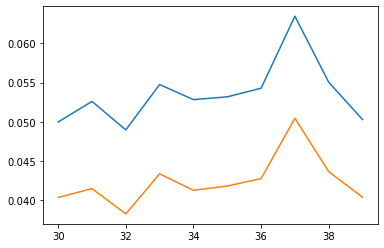

In [55]:
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[3]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[3]["MAE"])


In [56]:
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[10]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[10]["MAE"])


KeyError: 10